In [1]:
from model_generate import Diffusion
from model_update import DDPM_enhance
from data import BepiPredDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn.utils.rnn import pad_sequence
import os
import pandas as pd
from tqdm import tqdm
import math
from scipy.stats import norm
import random
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
random.seed(418)  # 设置种子值


GPU device not detected. Using CPU: cpu


In [2]:
### SET GPU OR CPU ###
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device detected: {device}")
else:
    device = torch.device("cpu")
    print(f"GPU device not detected. Using CPU: {device}")
    

GPU device not detected. Using CPU: cpu


torch.Size([8, 7, 1281])
torch.Size([8, 7])


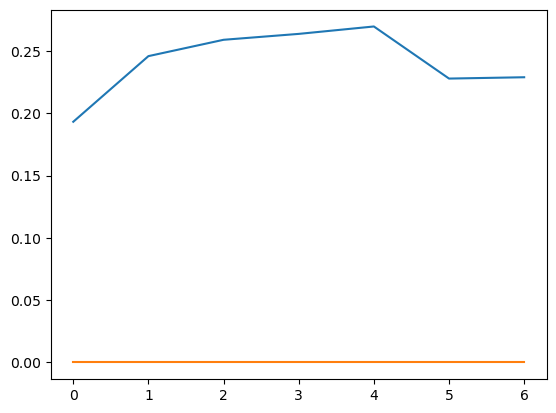

In [16]:
# 获取所有ESM编码文件路径列表
bepi_files = list(Path("data/BepiPred_outputs").glob("*.pt"))

# 划分训练集和测试集
train_files, test_files = train_test_split(bepi_files, test_size=0.2, random_state=42)
train_bepi_dataset = BepiPredDataset(train_files)
test_bepi_dataset = BepiPredDataset(test_files)


def collate_fn(batch):
    # 每个样本是 (input_tensor, target_tensor)
    input_seqs = [item[0] for item in batch]
    target_seqs = [item[1] for item in batch]
    pred_seqs = [item[2] for item in batch]


    # 两个序列的长度是一样的，可以统一 pad 成 max_len
    # 你也可以分别 pad（如果以后变成不一样长）

    input_padded = pad_sequence(input_seqs, batch_first=True, padding_value=0)
    target_padded = pad_sequence(target_seqs, batch_first=True, padding_value=0)
    pred_padded = pad_sequence(pred_seqs, batch_first=True, padding_value=0)

    return input_padded, pred_padded, target_padded
    
train_bepi_dataloader = DataLoader(train_bepi_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_bepi_dataloader = DataLoader(test_bepi_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


for esm, pred, epitope in train_bepi_dataloader:
    print(esm.shape)
    plt.plot(pred[0], label='pred')
    plt.plot(epitope[0], label='epitope')
    print(epitope.shape)
    break

In [4]:
# checkpoint
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f'Checkpoint saved to {checkpoint_path}')

def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [5]:
DDPM_Predicet_model = DDPM_enhance()
diffusion = Diffusion()
optimizer = optim.Adam(DDPM_Predicet_model.parameters(), lr=0.001)

In [6]:
def train(model, dataloader, optimizer, steps=1000, device=device, epochs=10):
    model.train()
    epochs_losses = []  # 记录每个epoch的平均损失

    for epoch in range(epochs):
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        loss_record= []
        for esm, pred, mask in progress_bar:  # esm: 真实ESM嵌入 [B, L, D]
            esm = esm.to(device)
            pred = pred.to(device)
            mask = mask.to(device)
            
            # print(mask.shape)
            # print(esm.shape)
            # 1. 随机采样时间步和噪声
            t = torch.randint(0, steps, (mask.size(0),), device=device)
            noise = torch.randn_like(mask)
            
            # 2. 前向加噪（根据噪声调度）
            noisy_mask = diffusion.q_sample(mask.unsqueeze(-1), t)
            t = t.float()

            # 3. 预测噪声并计算损失
            pred_noise = model(noisy_mask, esm, pred, t)

            # 4. 计算表位分类损失
            loss = F.mse_loss(pred_noise, noise)
            
            # 4. 反向传播
            optimizer.zero_grad()
            loss.backward()
            loss_record.append(loss.item())
            optimizer.step()
            
            # 5. 记录损失
            progress_bar.set_postfix({"loss": loss.item()})
            epoch_loss = torch.tensor(loss_record).mean().item()

        epochs_losses.append(epoch_loss)
        # 每15个epoch保存一次checkpoint
        if (epoch + 1) % 5 == 0:
            save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir)
            print(f"Epoch {epoch + 1}, Loss_Mean: {epoch_loss}", end="\r")
            plt.plot(epochs_losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()



Checkpoint saved to ./checkpoints/checkpoint_epoch_5.pth


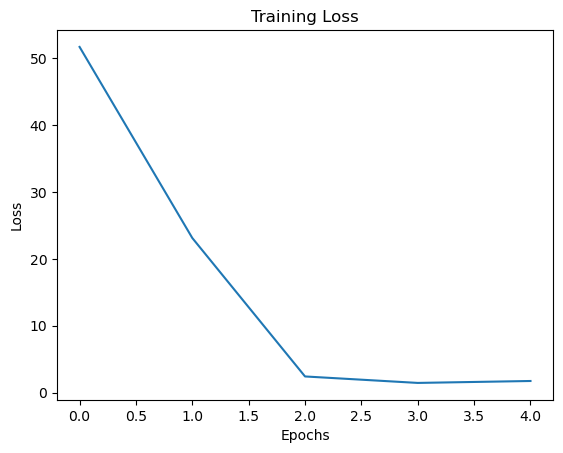

Checkpoint saved to ./checkpoints/checkpoint_epoch_10.pth


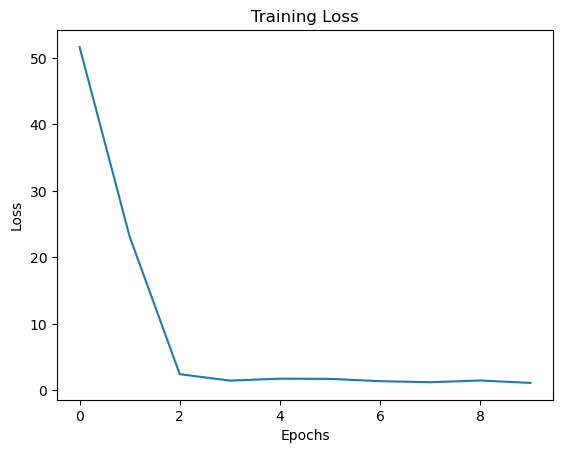

In [7]:

train(DDPM_Predicet_model, train_bepi_dataloader, optimizer)


In [8]:
@torch.no_grad()
def ddpm_sampling(model, esm_seq, bepi_scores, num_steps=1000):
    """
    Args:
        model: 训练好的 EpitopeTransformerDDPM 模型
        scheduler: 噪声调度器（如 SimpleNoiseScheduler）
        esm_seq: (B, L) 蛋白质序列
        bepi_scores: (B, L) BepiPred得分（0~1）
        num_steps: T，采样步数
        
    Returns:
        x0: (B, L) 最终生成的掩码（0~1）
    """

    device = esm_seq.device
    B, L,  _= esm_seq.shape
    x_t = torch.randn(B, L, 1).to(device)  # 初始纯噪声

    for t_index in range(num_steps - 1, -1, -1):
        t = torch.full((B,), t_index, device=device, dtype=torch.long)
        # 模型预测噪声
        pred_noise = model(x_t, esm_seq, bepi_scores, t).unsqueeze(-1)  # (B, L, 1)

        x_t = diffusion.p_sample(x_t, pred_noise, t, t_index)
        
    # 输出最终 x0
    x0 = x_t.squeeze(-1)  # (B, L)
    x0 = torch.sigmoid(x0)    # 保证在 [0,1] 概率范围（推荐）

    return x0  # 每个位点为表位的概率分布



In [10]:
def sample(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        for esm, pred, mask in test_dataloader:
            esm = esm.to(device)
            pred = pred.to(device)
            mask = mask.to(device)
            pred_mask = ddpm_sampling(model, esm, pred)
            pred_mask = pred_mask.cpu().numpy()
    return mask, pred_mask
mask, pred_mask = sample(DDPM_Predicet_model, test_bepi_dataloader)
